# MobileNet V2
Like a breeze after ResNet50

# Part I. Architecture Overview.
Picture below is an example of MobileNet V2 bottleneck block.<br>
Network is built of these blocks & uses simplified idea of ResNet.<br>
We do not use skip connection when downsampling/changing number of channels.<br>
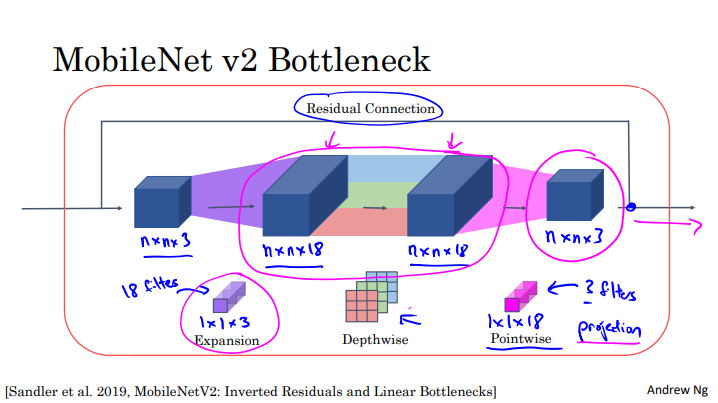 <br>
MobileNet V2 improves idea of MobileNetV1 (separate depthwise & pointwise convolutions) adding skip-connections on top<br>
Preem!

## Part II. Data
For this task I'll use beloved CIFAR100, which I use throughout this series

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, RandomSampler
from torchinfo import summary
from torchmetrics import Accuracy

import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
data_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomCrop((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

In [4]:
train_dataset = datasets.CIFAR100(root="./data", train=True, transform=data_transform, download=True)
val_dataset = datasets.CIFAR100(root="./data", train=True, transform=data_transform, download=True)
test_dataset = datasets.CIFAR100(root="./data", train=False, transform=data_transform, download=True)

train_dataset, val_dataset, test_dataset

100%|██████████| 169M/169M [00:03<00:00, 49.3MB/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR100
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=True)
                RandomCrop(size=(224, 224), padding=None)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
            ),
 Dataset CIFAR100
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=True)
                RandomCrop(size=(224, 224), padding=None)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                Normalize(mean=[0.5071

In [5]:
train_ratio = 0.8
m_samples = len(train_dataset)
indices = np.arange(m_samples)
np.random.seed(42)
np.random.shuffle(indices)

train_indices = indices[:int(m_samples * train_ratio)]
val_indices = indices[int(m_samples * train_ratio):]

train_sampler = RandomSampler(train_indices)
val_sampler = RandomSampler(val_indices)

train_dataloader = DataLoader(train_dataset,
                             batch_size=128,
                             num_workers=os.cpu_count(),
                             pin_memory=True,
                             sampler=train_sampler)

val_dataloader = DataLoader(val_dataset,
                             batch_size=128,
                             num_workers=os.cpu_count(),
                             pin_memory=True,
                             sampler=val_sampler)

test_dataloader = DataLoader(val_dataset,
                             batch_size=128,
                             num_workers=os.cpu_count(),
                             pin_memory=True)

len(train_dataloader) * 128, len(val_dataloader) * 128, len(test_dataloader) * 128

(40064, 10112, 50048)

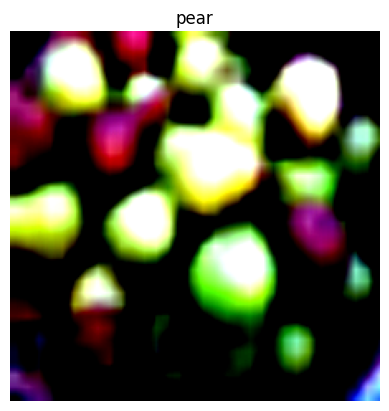

In [6]:
for image_batch, label_batch in train_dataloader:
    image = image_batch[0]
    label = label_batch[0]

    plt.axis("off")
    plt.title(train_dataset.classes[label])
    plt.imshow(image.permute(1, 2, 0));
    break

## Part III. Architecture

Here fun begins!

In [7]:
class InvertedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expansion, stride):
        super().__init__()
        hidden_dim = in_channels * expansion
        self.use_residual = stride == 1 and in_channels == out_channels
        
        self.block = nn.Sequential(
            # 1. Expansion
            nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),

            # 2. Depthwise Conv
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),

            # 3. Projection
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        if self.use_residual:
            return x + self.block(x)
        else:
            return self.block(x)

In [8]:
class MobileNetV2(nn.Module):
    def __init__(self, in_channels=3, num_classes=100):
        super().__init__()
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )

        self.features = nn.Sequential(
            InvertedResidualBlock(32, 16, expansion=1, stride=1),
            InvertedResidualBlock(16, 24, expansion=6, stride=2),
            InvertedResidualBlock(24, 32, expansion=6, stride=2),
            InvertedResidualBlock(32, 64, expansion=6, stride=2),
            InvertedResidualBlock(64, 96, expansion=6, stride=1),
            InvertedResidualBlock(96, 160, expansion=6, stride=2),
            InvertedResidualBlock(160, 320, expansion=6, stride=1),
        )

        self.final_conv = nn.Sequential(
            nn.Conv2d(320, 1280, kernel_size=1, bias=False),
            nn.BatchNorm2d(1280),
            nn.ReLU6(inplace=True)
        )

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.features(x)
        x = self.final_conv(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [9]:
mobilych_debilych = MobileNetV2()
summary(mobilych_debilych, input_size=(128, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV2                              [128, 100]                --
├─Sequential: 1-1                        [128, 32, 112, 112]       --
│    └─Conv2d: 2-1                       [128, 32, 112, 112]       864
│    └─BatchNorm2d: 2-2                  [128, 32, 112, 112]       64
│    └─ReLU6: 2-3                        [128, 32, 112, 112]       --
├─Sequential: 1-2                        [128, 320, 7, 7]          --
│    └─InvertedResidualBlock: 2-4        [128, 16, 112, 112]       --
│    │    └─Sequential: 3-1              [128, 16, 112, 112]       1,984
│    └─InvertedResidualBlock: 2-5        [128, 24, 56, 56]         --
│    │    └─Sequential: 3-2              [128, 24, 56, 56]         5,136
│    └─InvertedResidualBlock: 2-6        [128, 32, 28, 28]         --
│    │    └─Sequential: 3-3              [128, 32, 28, 28]         10,000
│    └─InvertedResidualBlock: 2-7        [128, 64, 14, 14]         --
│   

In [10]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    accuracy_fn = Accuracy("multiclass", num_classes=100).to(device)
    running_loss, running_acc = 0, 0

    model.train()
    
    for image_batch, label_batch in dataloader:
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)

        logits = model(image_batch)
        activated_pred = torch.softmax(logits, dim=1).argmax(dim=1)

        batch_accuracy = accuracy_fn(activated_pred, label_batch)
        batch_loss = loss_fn(logits, label_batch)
        running_loss += batch_loss
        running_acc += batch_accuracy

        optimizer.zero_grad()
        batch_loss.backward()
        # nn.utils.clip_grad_norm_(inception.parameters(), max_norm=10)
        optimizer.step()

    running_loss /= len(dataloader)
    running_acc /= len(dataloader)

    return running_loss, running_acc


def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              device: torch.device):
    accuracy_fn = Accuracy("multiclass", num_classes=100).to(device)
    running_loss, running_acc = 0, 0

    model.eval()
    
    with torch.inference_mode():
        for image_batch, label_batch in dataloader:
            image_batch = image_batch.to(device)
            label_batch = label_batch.to(device)
    
            logits = model(image_batch)
            activated_pred = torch.softmax(logits, dim=1).argmax(dim=1)
    
            batch_accuracy = accuracy_fn(activated_pred, label_batch)
            batch_loss = loss_fn(logits, label_batch)
            running_loss += batch_loss
            running_acc += batch_accuracy
    
        running_loss /= len(dataloader)
        running_acc /= len(dataloader)
    return running_loss, running_acc

## Part IV. Training

In [15]:
num_classes = 100
num_epochs = 15
learning_rate = 0.0001

model = MobileNetV2().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_dataloader)

In [32]:
num_epochs = 5
optimizer = torch.optim.Adam(model.parameters(), lr=0.000005)

In [33]:
train_step = len(train_dataloader)
val_step = len(val_dataloader)

for epoch in range(num_epochs):
    # Train step
    model.train()
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        outputs = torch.softmax(logits, dim=1).argmax(dim=1)
        loss = loss_fn(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train| Step {i+1}/{train_step}, Loss: {loss.item():.4f}")

    # Validation step
    model.eval()
    with torch.inference_mode():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(val_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)

            loss = loss_fn(logits, labels)
            
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, logits

        print(f"Val| Step {i+1}/{val_step}, Loss: {loss.item():.4f}, Accuracy: {100*correct/total:.4f}")
        print("="*60)

Epoch 1/5
Train| Step 313/313, Loss: 1.5230
Val| Step 79/79, Loss: 1.5621, Accuracy: 58.1500
Epoch 2/5
Train| Step 313/313, Loss: 1.5402
Val| Step 79/79, Loss: 1.4102, Accuracy: 59.1200
Epoch 3/5
Train| Step 313/313, Loss: 1.8510
Val| Step 79/79, Loss: 1.8062, Accuracy: 59.3300
Epoch 4/5
Train| Step 313/313, Loss: 1.9458
Val| Step 79/79, Loss: 1.2116, Accuracy: 58.8600
Epoch 5/5
Train| Step 313/313, Loss: 1.7325
Val| Step 79/79, Loss: 1.4768, Accuracy: 58.6600
